In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime
import gc
import random
import re
import operator
import pickle
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,log_loss

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.optimizer import Optimizer

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

# stemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")

def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.backends.cudnn.benchmark = False

def init_func(worker_id):
    np.random.seed(SEED+worker_id)

tqdm.pandas()
SEED=42
seed_everything(SEED=SEED)

# noting down the run time of the kernel
t1=datetime.datetime.now()

Using TensorFlow backend.


In [2]:
train=pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test=pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
sample=pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv")
print(train.shape,test.shape)

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
train[identity_columns]=train[identity_columns].fillna(0)

display(train.head())
display(test.head())

(1804874, 45) (97320, 2)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [3]:
def build_vocab(sentences,verbose=True):
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        for word in sentence:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
                
    print("Number of words found in vocab are",len(vocab.keys()))
    return dict(sorted(vocab.items(), key=operator.itemgetter(1))[::-1])

def sen(x):
    return x.split()

def check_coverage(vocab,embeddings_dict):
    # words that dont have embeddings
    oov={}
    # stores words that have embeddings
    a=[]
    i=0
    k=0
    for word in tqdm(vocab.keys()):
        if embeddings_dict.get(word) is not None:                    # implies that word has embedding
            a.append(word)
            k=k+vocab[word]
        else:
            oov[word]=vocab[word]
            i=i+vocab[word]
    
    print("Total embeddings found in vocab are",len(a)/len(vocab)*100,"%")
    print("Total embeddings found in text are",k/(k+i)*100,"%")
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return dict(sorted_x)

In [4]:
contraction_mapping={"ain't": 'is not', "amn't": 'am not', "aren't": 'are not', 
                     "can't": 'cannot',"CAN'T":"CANNOT","'cause": 'because', "could've": 'could have', 
                     "couldn't": 'could not', "couldn't've": 'could not have', "daren't": 'dare not', 
                     "daresn't": 'dare not', "dasn't": 'dare not', 
                     "didn't": 'did not', "doesn't": 'does not', 
                     "don't": 'do not',"DON'T":"DO NOT","e'er": 'ever', "everyone's": 'everyone is', 
                     'giv’n': 'given', "gon't": 'go not', "hadn't": 'had not', 
                     "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', 
                     "he'll": 'he will', "he's": 'he is', 
                     "he've": 'he have', "how'd": 'how would', 
                     'howdy': 'how do you do', "how'll": 'how will', 
                     "how're": 'how are', "how's": 'how is', "I'd": 'I would', 
                     "I'll": 'I will', "I'm": 'I am', "i'm":"i am",
                     "I'm'a": 'I am about to', "I'm'o": 'I am going to',"i've":"i have",
                     "I've": 'I have', "isn't": 'is not', "it'd": 'it would', "it'll": 'it will', 
                     "it's": 'it is',"IT'S":"IT IS","let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', 
                     "may've": 'may have', "mightn't": 'might not', 
                     "might've": 'might have', "mustn't": 'must not', "mustn't've": 'must not have', 
                     "must've": 'must have', "needn't": 'need not', 
                     "ne'er": 'never', "o'clock": 'of the clock', "o'er": 'over', "ol'": 'old', 
                     "oughtn't": 'ought not', "shalln't": 'shall not', "shan't": 'shall not', 
                     "she'd": 'she would', 
                     "she'll": 'she will', "she's": 'she is', "should've": 'should have', 
                     "shouldn't": 'should not', "shouldn't've": 'should not have', 
                     "somebody's": 'somebody is', 
                     "someone's": 'someone is', "something's": 'something is', 
                     "so're": 'so are', "that'll": 'that will', "that're": 'that are', 
                     "that's": 'that is', "that'd": 'that had', 
                     "there'd": 'there would', "there'll": 'there will',
                     "there're": 'there are', "there's": 'there is',
                     "these're": 'these are', "they'd": 'they would', 
                     "they'll": 'they will', "they're": 'they are', 
                     "they've": 'they have', "this's": 'this is', 
                     "those're": 'those are', "'tis": 'it is', "'twas": 'it was', "wasn't": 'was not', 
                     "we'd": 'we would', "we'd've": 'we would have', 
                     "we'll": 'we will', "we're": 'we are', "we've": 'we have', "weren't": 'were not', 
                     "what'd": 'what did', "what'll": 'what will', "what're": 'what are',
                     "what's": 'what is', "what've": 'what have', 
                     "when's": 'when is', "where'd": 'where did', 
                     "where're": 'where are', "where's": 'where is', 
                     "where've": 'where have', "which's": 'which is', "who'd": 'who would', 
                     "who'd've": 'who would have', "who'll": 'who will', "whom'st": 'whom hast', 
                     "whom'st'd've": 'whom hast had have', "who're": 'who are', 
                     "who's": 'who is', "who've": 'who have', 
                     "why'd": 'why did', "why're": 'why are', "why's": 'why is', 
                     "won't": 'will not', "would've": 'would have', "wouldn't": 'would not', 
                     "y'all": 'you all', "y'all'd've": 'you all would have', 
                     "you'd": 'you would', "you'll": 'you will', "you're": 'you are', "you've": 'you have',
                    "here's":"here is"}

mispelled_dict={'tRump':"trump","gov't":"governement","Gov't":"Government","Brexit":"British exit",
               "sayin'":"saying","Qur'an":"Quran","Drumpf":"Donald Trump",'SB91':"senate bill",
               "FAKEnews":"FAKE NEWS","OBAMAcare":"obamacare","TheDonald":"The Donald"}

# adding single puntucation mark...
# puncts=[',','.','!','$','(',')','%','[',']','?',':',";","#",'/','"',
#                 "-","|",'*',"'","+",">","<","=","\n","^","-",""]
puncts = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + "'" + '“”’' 

# specials characters are also included in this...
puncts_mapping={'—':"-", "–":"-" ,'”':'"', "’":"'", "´": "'", "`":"'" , '…':'...', "\'":"'",
                '“':'"' ,"✰":"*","ᴀɴᴅ":"AND","―":"-","ᴛʜᴇ":"THE","…and":"... and",
               "é":"e","ᴀ":"A","ï":"i","à":"a"}

symbols_to_delete='\n\xadᴇᴏɴᴵ\u2004ᴛ\tᴀʀʜᴍᴜᴄʏʟᴅғᴋʙɢ\u200bᴡᴘ😂️𝒆😁🔥🌮😉𝒕𝒂т𝒊😀𝒏🆘𝒐\u2005ᴊ👍🙄😊ᴠно\u200e▱\x7fι𝒔𝙚\u2006𝒓😃😄е\u2009\u2028𝒉😆💀👎😜𝙖😡𝒅𝒍𝙩𝙤🤔🌯ο😎💨рΜ🤣ѕ𝒖𝙣𝙧💥𝒄м𝗲л💙𝙨╌ς🏻𝒎\u200a\u202c😢𝙞υ\u200f😅𝒑к𝙡д😇\u202a💩🇺ا𝙙𝒚𝗼𝙝𝘁🇸👏ьуκ🙏𝒇𝒈𝙪п𝒘ل𝗶\x10\r𝒗𝐞𝗻😳𝗿𝖔𝙮𝐭𝗮й😍𝒃𝙥𝙘б🙂🏼𝘀😝👥\u2002𝘦\x08𝖊я😕😑😬😏𝙛😭𝗵𝐚ы⤵ஜ\uf0a7\u200d𝘵🏾\ufeff😩𝙜ч𝘪😘𝗹з😲😠😈𝖙ｅ𝘂ℐгά𝖓𝘆🤡😒💰😔𝖚𝒌𝙬𝗱\u2003😴🙈🏽😱Ｗц\uf0b7👤🤓𝘢‑🎶\u3000ｎ𝙗𝐨𝘰😞ίي𝙢𝐰𝐫ツ🤑😣مبｔ𝖆👋🇨👿😛𝘴😨𝖞𝖗𝘯𝗰🇦🐱💔🌟𝖉𝖎🦊𝙃⏖😰ό🏆А😥😟😐𝐥𝐬𝐡的С͞יن🏐𝗺\u200c𝘥𝐮🇷🎼шέ🤗Пוر𝑰𝖑🤷𝑻𝗽𝗯ж😯🐟🐕𝘳ه𝘭𝗳М🤧💜\u202dх🙌𝘮🙃😪😤‼⩛😦𝙠𝐦𝐜юЯ大￼👌‐😖وعｕｉ🇳𝖜𝙫𝐛𝐧Д😵🙁تὶ😮לأق𝘩𝖋𝖒𝖍𝘶我щР有卖🤢豆土小👆𝘣💕🎉ἀἐ😋ｄ𝖘𝘃𝘼ｈ🍆🍁И💚𝘤🌺ةس💪💯א😧ḵ𝗴🤕ῆ𝐯𝐢𝐩😷了🍔🌎税加去国🇹👉🙉حήש🐵ｒ𝒙🐸𝑪𝙀𝑶🔫🎫𝟔ῦ😫🍑🤥钱所你З不ר🙊👀𝘧زكע\x81💖خد\uf04aῖὺ🤞𝑬ὰ𝙔⛷𝙭🐀ج𝐝ｙ𝘄🇪🤠🤤͟🎵拿失是人🌞🤐הف👮ξὲםὴὑｂｆ𝑷」𝑫𝑹𝖕𝖌𝙈다他中ℴ𝓉𝙄收𝑴БТ𝐓看🗽🤦🌍ύὐἔ会つ文\u202f🌏😌⏺👄דמʰᵗ🐾𝘺😓\u2008🚲🙀👊🍕ῶ᾽🔼𝐍♲𝘓𝘸𝘱ա𝑺「𝒒𝑯🏉𝑱𝘨𝑾🚿𝖈𝕴𝖛没法想𝒾ℯ₵니어𝟱要🐈来🐒🤙美👹😙👽🏃𝙇💐𝐅𝐘𝐲𝐃ｌʁ🇮说可קФ💃\x9d💋🌸💤ת🚬💛💎💫Нחン💵�◝ἰ🇴𝐊➕↴ώ𝘷𝘬Λ𝑩Г𝗕𝑮ی👨🐴ф\uf020🇵𝑵𝙒𝑲𝒛𝖐마에나합야해을이도😶🦁战教本和𝟭ζ𝒽𝓃𝓇𝒶ʖ͜ニ𝟬买巨🦄🚂У🐷👺💘𝟓𝐱𝐔𝐳𝟎ןһ📺\x1fХ🇩🇫一以𝓲ệ😺О🚀ءشإ🐝下ḷ༽༼📣🎄系关》⁉❔👐🚓💞ὁᾶ\x9f👶👅טὸʳэ🎃🚽💗🍻🎆🌹כЕىص🐶\uf032\uf02f\uf070̛⁍⁎🇾ἄῷ🙇ლ《🌈👼🇻ｋｇ😼𝑭🐻🎨⊘💒Βک𝘹𝘖𝘐🤚🔹ὀրեχἡἈ𝗜𝒀\ue600\uf410\ue607\uf469\uf099\uf202\ue608\uf222\uf09a\uf203چ🐲🍗\x0bっ👣版查击点🛳🐎🎈🐄ᐧᐃᔭ🇰𝘾𝒋百知💡𝕸𝖄𝖇凸품약캐리지들제상가뤼트탱스쥐胜稣耶让经士传己自问如对为🏹⛓🎻多𝟲𝟯𝓀𝓈社式株ロチハルマ𝟳𝐠𝟏ﷻ𝙅𝙋𝙆𝙊פס到寓公🎾Л₽̯☘𝓬ીતારજુગіɜᵻ💸ͦ🤘𝐪🌅ё💓ﬃ𝐇𝐑܁ᏧΤ\u2007ͺᴦսϖ𝗪给🌐🇬⬯⬭⚆⚲🖒👩极好话在🍀К🏈别🍺🎅子🗑\x9cサ🇼म्रक🏀\uf04c🎓͝ᵒ🍰🙅🖐\x95🏿地𝘊🙆🍽👻Ｈἴ⛽בغ🌙\uf029\uf061\uf02d\uf028\uf031\uf03d\uf071ὠἕᴗ⒍⒌⒋⒊⒉⒈ዎአ🕊卍卐🕍💝𝙯🎭ὖἅἑὅὡῳ🐢らなうよさ🥜𝗷𝗠𝗟𝗸ἱ💳🐡\U0001f92a\U0001f92f🐦ڡ\uf10a🐍🐊🔭🍦🍟📉𝗤𝗘𝗭𝗞🇲🇭𝟰🕷🎎🤖𝐎🌑🚫👈📍🥘🖤🖕🚴Ȼ𝝈🇱ΕΑΝΟ💢𝘫𝘲💅🐂🍎𝒁至冬ձդւնիյռմՁψ⤏🍊𝗧𝗦𝗙🌤屈理屁偽虚シ製燻💊ї件事リ鉄⏰🐑ⲏⲣꜥ🍒🕉👳🏂𝟐😗🍩🦍🤳Ξ🎥💭ＧＮ𝑧𝑦𝑥🍭🌝🎰💟🔨ᐣᓀᑎᑭᐸᑲᓂᓃᐨᑳᐦᒧᓇ👾ṑὼ𝘽𝟒𝑳\uf005彼👑𝖟𝖂𝕿𝕾Ἄ🗯💲👁용사된허시드반는때갈분성런의금화와초대서관잘록않만게렵황경인격유석🙋🏝讨检判批🎁⛑🤒🎸♾还样这谓栗且惧恐孩婚结堂全把圣因候时题治政些聊们当但怪死活复信相曾徒督基识认唯积猜用接直象其与贺祝谊友🦆🍷🎹🐽伦𝟮𝙟𝙏𝓎𝒸𝓌𝒻𝓅𝓊𝓁𝒩𝘿ㅓㄸ국한⦁𝗢拷斤锟👇𝟗𝟕𝟑𝟖𝐟🐳🚗ẽ额怒愤鬼白得赢𝙍斯拉阿迎欢操🚑🏄吗物宠养⛸🏒⎌‒\ue807﴿﴾𝓼𝓽𝓮𝓴𝓻🚢👃👂티패Ἱ🚶𝐀ℋ🌄🌋🐋Ꭻ〔౦ᗞԜ𝐂𝐣𝐙ᴑІ௦໐ᑯᴨƄƽ൦ɩ\u2001հᎥү\u2000𝘅𝘇猴鸡杀Ш🇧✀新⚭家天🚪🎊🎇🥂🍸🕺语汉通普生出ћљЖ요세하영안𝓵𝓿𝓒🐮⏏园明圆群戦作殊特ύ🖑ʲ🤴克油آ骗坏降议华哥温َِ外スクレ🎲英蔡ा👠🏡\ue613🍇📚🔔Ἰ都成🔛👲🔤🔄🆕צךנף\ue602\x13ᵘᵉʷᴺᴷᴼʸˢ⛲🌠伎舞歌🔗谷獄🐇🐰🍾ط⛺ῃ🎯🚄🚌障故ジエ\uf0e0\uf818\ue014'
remove_dict={ord(c):"" for c in symbols_to_delete}

# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
def remove_url(x):
    # it is for removing url from the text..
    x=re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE)
    x=re.sub(r'http\S+','',x,flags=re.MULTILINE)
    return x

def replace_puncts_mapping(x):
    for i in puncts_mapping.keys():
        x=x.replace(i,puncts_mapping[i])
        
    return x


def replace_contraction_mapping(x):
    for contract in contraction_mapping.keys():
        x=x.replace(contract,contraction_mapping[contract])
        x=x.replace(contract.capitalize(),contraction_mapping[contract].capitalize())
#         x=x.replace(contract.upper(),contraction_mapping[contract].upper())
        
    return x

# https://dictionary.cambridge.org/grammar/british-grammar/writing/contractions
# preprocessing for nouns
def fix_noun_contractions(x):
    x=x.replace("'s","")

    return x

def fix_spellings(x):
    for mispelled_word in mispelled_dict:
        x=x.replace(mispelled_word,mispelled_dict[mispelled_word])
        
    return x

def replace_puncts(x):
    for p in puncts: 
        x=x.replace(p,f' {p} ')          # adding spaces to desirerd puncts
#         x=x.replace(p,"")            # removing the puncts from the vocab..
    
    x=x.translate(remove_dict)
    return x


train['comment_text']=train['comment_text'].progress_apply(remove_url)
train['comment_text']=train['comment_text'].progress_apply(replace_puncts_mapping)       
train['comment_text']=train['comment_text'].progress_apply(replace_contraction_mapping)
train['comment_text']=train['comment_text'].progress_apply(fix_noun_contractions)
train['comment_text']=train['comment_text'].progress_apply(fix_spellings)
train['comment_text']=train['comment_text'].progress_apply(replace_puncts)
# train_sentences=train['comment_text'].progress_apply(sen)

test['comment_text']=test['comment_text'].progress_apply(remove_url)
test['comment_text']=test['comment_text'].progress_apply(replace_puncts_mapping)
test['comment_text']=test['comment_text'].progress_apply(replace_contraction_mapping)
test['comment_text']=test['comment_text'].progress_apply(fix_noun_contractions)
test['comment_text']=test['comment_text'].progress_apply(fix_spellings)
test['comment_text']=test['comment_text'].progress_apply(replace_puncts)
# test_sentences=test_sentences.progress_apply(sen)

# vocab=build_vocab(train_sentences)
# oov=check_coverage(vocab,embeddings_dict_glove)

100%|██████████| 97320/97320 [00:03<00:00, 31017.25it/s]


## TOKENIZING AND PADDING

In [5]:
%%time
max_words=300000              # 1 lakh top words (vocab nearly contains 4 lakh words)
max_len=250
embed_dim=300

# I am keeping filters as default of the keras...
tokenizer=Tokenizer(num_words=max_words,lower=False)
tokenizer.fit_on_texts(list(train['comment_text']))
print("The length of vocabulary is",len(tokenizer.word_index))

X=tokenizer.texts_to_sequences(list(train['comment_text'].values))
X_test=tokenizer.texts_to_sequences(list(test['comment_text'].values))

# padding and truncating
print("Padding and truncating")
X=np.array(pad_sequences(X,maxlen=max_len,padding='pre',truncating='pre',dtype='int32'),dtype='int32')
X_test=np.array(pad_sequences(X_test,maxlen=max_len,padding='pre',truncating='pre'),dtype='int32')

# for i in ['severe_toxicity','obscene','identity_attack','insult','threat']:
#     train[i]=(train[i]>=0.5).astype(int)

# defining auxilary training
aux_cols=['target','severe_toxicity','obscene','identity_attack','insult','threat']
print(len(aux_cols))
y_aux=train[aux_cols].values
train['target']=(train['target']>=0.5).astype(int)
y=train['target'].values

y=np.hstack((y.reshape(-1,1),y_aux))

print("Training Shape",X.shape,y.shape)
print("Test Shape",X_test.shape)

The length of vocabulary is 369892
Padding and truncating
6
Training Shape (1804874, 250) (1804874, 7)
Test Shape (97320, 250)
CPU times: user 3min 57s, sys: 2.9 s, total: 4min
Wall time: 4min


## EMBEDDING MATRIX

In [6]:
%%time
def give_embed_matrix(word_index,embeddings_dict):
    nb_words=min(max_words,len(word_index)+1)
    embeddings_matrix = np.zeros((nb_words, embed_dim))
    for word,index in word_index.items():
        if index>=max_words:
            continue
        # implies that word has embedding
        if embeddings_dict.get(word) is not None:
            embeddings_matrix[index] = embeddings_dict.get(word)
        
        elif embeddings_dict.get(word.lower()) is not None:
            embeddings_matrix[index] = embeddings_dict.get(word.lower())
        
        elif embeddings_dict.get(word.upper()) is not None:
            embeddings_matrix[index] = embeddings_dict.get(word.upper())
        
        elif embeddings_dict.get(word.capitalize()) is not None:
            embeddings_matrix[index] = embeddings_dict.get(word.capitalize())
            
        elif embeddings_dict.get(ps.stem(word)) is not None:
            embeddings_matrix[index] = embeddings_dict.get(ps.stem(word))
            
        elif embeddings_dict.get(lc.stem(word)) is not None:
            embeddings_matrix[index] = embeddings_dict.get(lc.stem(word))
        
        elif embeddings_dict.get(sb.stem(word)) is not None:
            embeddings_matrix[index] = embeddings_dict.get(sb.stem(word))
            
    return embeddings_matrix

print("Extracting GloVe embedding")
with open("../input/pickledglove300d22mforkernelcompetitions/glove.2M.840B.300d.pkl",'rb') as f:
    embeddings_dict_glove = pickle.load(f)
print("Number of embeddings loaded:",len(embeddings_dict_glove))

# print("Extracting GloVe embedding")
# with open("../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl",'rb') as f:
#     embeddings_dict_glove = pickle.load(f)
# print("Number of embeddings loaded:",len(embeddings_dict_glove))

embeddings_matrix_glove=give_embed_matrix(tokenizer.word_index,embeddings_dict_glove)
print("The Shape of the glove matrix is",embeddings_matrix_glove.shape)

gc.enable()
del embeddings_dict_glove
gc.collect()

print("Extracting Fast Text embedding")
with open("../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl",'rb') as f:
    embeddings_dict_fasttext = pickle.load(f)
print("Number of embeddings loaded:",len(embeddings_dict_fasttext))

embeddings_matrix_fasttext=give_embed_matrix(tokenizer.word_index,embeddings_dict_fasttext)
print("The Shape of the fasttext matrix is",embeddings_matrix_fasttext.shape)

gc.enable()
del embeddings_dict_fasttext
gc.collect()


print("Extracting Fast Text SubWord Embedding")
with open("../input/pickled-fasttext-subword/fasttext_subword.2M.600B.300d.pkl","rb") as f:
    embeddings_dict_fasttext_subword = pickle.load(f)
print("Number of embeddings loaded:",len(embeddings_dict_fasttext_subword))

embeddings_matrix_fasttext_subword = give_embed_matrix(tokenizer.word_index,embeddings_dict_fasttext_subword)
print("The Shape of the fasttext subword matrix is",embeddings_matrix_fasttext_subword.shape)

gc.enable()
del embeddings_dict_fasttext_subword
gc.collect()

print("Extracting fasttext wikinews embedding")
with open("../input/pickled-fasttext-wikinews/wikinews.1M.16B.300d.pkl","rb") as f:
    embeddings_dict_wikinews = pickle.load(f)
print("Number of embeddings loaded:",len(embeddings_dict_wikinews))

embeddings_matrix_wikinews = give_embed_matrix(tokenizer.word_index,embeddings_dict_wikinews)
print("The Shape of the wikinews matrix is",embeddings_matrix_wikinews.shape)

gc.enable()
del embeddings_dict_wikinews
gc.collect()

Extracting GloVe embedding
Number of embeddings loaded: 2196017
The Shape of the glove matrix is (300000, 300)
Extracting Fast Text embedding
Number of embeddings loaded: 2000000
The Shape of the fasttext matrix is (300000, 300)
Extracting Fast Text SubWord Embedding
Number of embeddings loaded: 2000000
The Shape of the fasttext subword matrix is (300000, 300)
Extracting fasttext wikinews embedding
Number of embeddings loaded: 1000000
The Shape of the wikinews matrix is (300000, 300)
CPU times: user 54.5 s, sys: 9.62 s, total: 1min 4s
Wall time: 1min 4s


In [7]:
# combining the embedding matrices 
embeddings_matrix = 0.3*embeddings_matrix_glove + 0.3*embeddings_matrix_fasttext + \
                    0.3*embeddings_matrix_fasttext_subword + 0.1*embeddings_matrix_wikinews


# embeddings_matrix=np.hstack((embeddings_matrix_glove,embeddings_matrix_fasttext,\
#                                      embeddings_matrix_fasttext_subword))

gc.enable()
del embeddings_matrix_glove,embeddings_matrix_fasttext,embeddings_matrix_fasttext_subword
gc.collect()           


# updating the embedding dimension
embed_dim=embeddings_matrix.shape[1]
print("Final Embeddings matrix shape",embeddings_matrix.shape)

Final Embeddings matrix shape (300000, 300)


In [8]:
import pickle

# saving the tokenizer and embeddings matrix for testing....
with open("tokenizer.pkl","wb") as handle:
    pickle.dump(tokenizer.word_index,handle)
    
# saving the embeddings matrix
np.save("embeddings_matrix.npy",embeddings_matrix)

## METRICS

In [9]:
# taken from the kernel https://www.kaggle.com/dborkan/benchmark-kernel
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

# making subgroups as 1 and 0 with threshold 0.5
# the nan value in some examples 
for subgroup in identity_columns:
    train[subgroup]=(train[subgroup]>=0.5).astype(np.int8)

def auc_score(y_true,y_pred):
    return roc_auc_score(y_true,y_pred)

def compute_bpsn(df,subgroup):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples.
    Here, we restrict the test set to the non-toxic examples that mention the identity and 
    the toxic examples that do not"""
    
    subgroup_negative_examples=df.loc[(df[subgroup]==1) & (df['target']==0)]
    non_subgroup_positive_examples=df.loc[(df[subgroup]==0)&(df['target']==1)]
    examples=pd.concat([subgroup_negative_examples,non_subgroup_positive_examples])
    
    return roc_auc_score(examples['target'].values,examples['preds'].values)
    
    
def compute_bnsp(df,subgroup):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples.
    Here, we restrict the test set to the toxic examples that mention the identity and 
    the non-toxic examples that do not."""
    subgroup_positive_examples=df.loc[(df[subgroup]==1)&(df['target']==1)]
    non_subgroup_negative_examples=df.loc[(df[subgroup]==0)&(df['target']==0)]
    examples=pd.concat([subgroup_positive_examples,non_subgroup_negative_examples])
    
    return roc_auc_score(examples['target'].values,examples['preds'].values)

def compute_bias_auc(indices=None,preds=None,df=None):
    """ Computes the three auc for all the subgroups """
    if df is None:
        df=train.copy()
        df['preds']=preds
        df=df.loc[indices].copy()
    
    records=[]
    for subgroup in identity_columns:
        record={
            'subgroup': subgroup,
            'subgroup_size': df.loc[df[subgroup]==1].shape[0]
        }
        record[SUBGROUP_AUC]=roc_auc_score(df.loc[df[subgroup]==1,'target'].values,
                                                       df.loc[df[subgroup]==1,'preds'].values)
        record[BPSN_AUC]=compute_bpsn(df,subgroup)
        record[BNSP_AUC]=compute_bnsp(df,subgroup)
        records.append(record)
    
    return pd.DataFrame(records)[['subgroup','subgroup_size',SUBGROUP_AUC,BPSN_AUC,BNSP_AUC]]

def compute_power_mean(series,p):
    total=np.sum(np.power(series,p))
    return np.power(total/len(series),1/p)

def compute_final_metric(indices,preds,overall_auc=None,p=-5,w=0.25):
    df=train.copy()
    df=df.loc[indices].copy()
    df['preds']=preds
    
    if overall_auc is None:
        overall_auc=roc_auc_score(df['target'],df['preds'])
    bias_df=compute_bias_auc(df=df)
    bias_score=np.average([
        compute_power_mean(bias_df[SUBGROUP_AUC],p),
        compute_power_mean(bias_df[BPSN_AUC],p),
        compute_power_mean(bias_df[BNSP_AUC],p),
    ])
    
    return bias_df,w*overall_auc+(1-w)*bias_score

In [10]:
# # preds=np.random.uniform(0,1,size=(train.shape[0],))
# preds=1/(1+np.exp(-np.random.normal(0,1,size=(train.shape[0],))))
# print(preds.shape)
# bias_df,score=compute_final_metric(train.index,preds)
# print(score)
# display(bias_df)

# taken from the kernel https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution
weights=np.ones((train.shape[0],))
weights = weights + train[identity_columns].sum(axis=1).astype(np.bool).astype(np.int).values

# Background Positive, Subgroup Negative
weights = weights + (( (train['target']>=0.5).astype(np.bool).astype(np.int) +  \
        (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(np.int).astype(np.bool) )>1)\
                    .astype(np.bool).astype(np.int)

# Background Negative, Subgroup Positive
weights = weights + (( (train['target']<0.5).astype(np.bool).astype(np.int) + \
        (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(np.int).astype(np.bool) )>1)\
                    .astype(np.bool).astype(np.int)

# weights = np.ones((train.shape[0],))
# weights = weights + train[identity_columns].sum(axis=1).values
# # bpsn
# weights = weights + (train['target']<0.5)*(train[identity_columns].fillna(0).values>=0.5).sum(axis=1) + \
#                     (train['target']>=0.5)*(train[identity_columns].fillna(0).values<0.5).sum(axis=1)

# # bnsp
# weights = weights + (train.loc[train['target']>=0.5][identity_columns].fillna(0).values>=0.5).sum(axis=1) + \
#                     (train.loc[])

weights=(weights.values)/np.mean(weights)
weights[0:10]

array([0.80230672, 0.80230672, 0.80230672, 0.80230672, 1.60461343,
       1.60461343, 0.80230672, 0.80230672, 0.80230672, 0.80230672])

## MODEL

In [11]:
class Attention(nn.Module):
    def __init__(self,hidden_dim,max_len):
        super(Attention,self).__init__()
        
        self.hidden_dim=hidden_dim
        self.max_len=max_len
        
        self.tanh=nn.Tanh()
        self.linear=nn.Linear(in_features=self.hidden_dim,out_features=1,bias=False)
        self.softmax=nn.Softmax(dim=1)        
        
    def forward(self,h):
        
        m=self.tanh(h)
        
        alpha=self.linear(m)
        
        alpha=torch.squeeze(alpha)           # shape of alpha will be batch_size*max_len
        
#         print("Alpha shape:",alpha.shape)
        
        # softmax(note that softmax is along dimension 1)
        alpha=self.softmax(alpha)
        
        # unsequezzing alpha to get shape as batch_size*max_len*1
        alpha=torch.unsqueeze(alpha,-1)
        
        # we have to define r
        r=h*alpha
        
        # now we have to take sum and shape of r is batch_size*hidden_size
        r=torch.sum(r,dim=1)
        
        return r

In [12]:
class SpatialDropout(nn.Module):
    def __init__(self,p=0.2):
        super(SpatialDropout,self).__init__()
        self.p = p
        self.dropout2d = nn.Dropout2d(p=self.p)
    
    def forward(self,embeddings):
        embeddings = torch.transpose(embeddings,1,2)  # (batch_size,embed_size,timestep)
        embeddings = torch.unsqueeze(embeddings,-1)  # (batch_size,embed_size,timestep,1)
        embeddings = self.dropout2d(embeddings)      # (batch_size,embed_size,timstep,1)
        embeddings = torch.squeeze(embeddings)      # (batch_size,embed_size,timestep)
        embeddings = torch.transpose(embeddings,1,2) # (batch_size,timestep,embed_size)
        
        return embeddings

# model params
hidden_units=64
class LstmGru(nn.Module):
    def __init__(self,embeddings_matrix,num_aux_targets):
        super(LstmGru,self).__init__()
        
        self.embedding=nn.Embedding.from_pretrained(torch.Tensor(embeddings_matrix),freeze=True)
        self.embedding_dropout = SpatialDropout(0.1)

#         self.embedding_linear = nn.Linear(in_features = embed_dim,out_features = 128)
#         self.embedding_relu = nn.ReLU()
        self.lstm=nn.LSTM(input_size=embed_dim,hidden_size=hidden_units,
                              bidirectional=True,batch_first=True)
        
        # gru output goes to lstm
        self.gru=nn.GRU(input_size=2*hidden_units,hidden_size=hidden_units,
                           bidirectional=True,batch_first=True)
        
        # lstm attention
        self.lstm_attention=Attention(2*hidden_units,max_len)
        
        # gru attention
        self.gru_attention=Attention(2*hidden_units,max_len)
        
        self.linear1=nn.Linear(in_features=8*hidden_units,out_features=32)
        self.batch1=nn.BatchNorm1d(32)
        self.relu1=nn.ReLU()
        self.drop1=nn.Dropout(0.25)
        
        self.linear2=nn.Linear(in_features=32,out_features=1)
        self.linear3=nn.Linear(in_features=32,out_features=num_aux_targets)
        
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,X):
        batch_size=X.shape[0]
        
        embeds=self.embedding(X.long())
        
        embeds=self.embedding_dropout(embeds)
        
#         embeds = self.embedding_relu(self.embedding_linear(embeds))
        
        h_lstm,_=self.lstm(embeds)
        h_gru,_=self.gru(h_lstm)
        
        # max pooling over time
        h_lstm_max,_=torch.max(h_lstm,1)
        h_gru_max,_=torch.max(h_gru,1)
        
        # mean average pooling over time
        h_lstm_mean=torch.mean(h_lstm,1)
        h_gru_mean=torch.mean(h_gru,1)
        
        # attention
        h_lstm_attend=self.lstm_attention(h_lstm)
        h_gru_attend=self.gru_attention(h_gru)
        
        h=torch.cat((h_lstm_attend,h_gru_attend,h_lstm_max,h_gru_max),dim=1)
        
        output=self.relu1(self.batch1(self.linear1(h)))
        output=self.drop1(output)
        
        linear_output=self.sigmoid(self.linear2(output))
        aux_output=self.sigmoid(self.linear3(output))
        
        output=torch.cat([linear_output,aux_output],dim=1)
        
        return output
    
def initialize_model(embeddings_matrix,num_aux_targets):
    model=LstmGru(embeddings_matrix,num_aux_targets)
    
    # setting all the dtypes to float
    model.float()
    
    # pushing the code to gpu
    model.cuda()
    
    # params
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("Total trainiable Param's are",trainable_params)
    
    return model

In [13]:
initialize_model(embeddings_matrix,y_aux.shape[1])

Total trainiable Param's are 278855


LstmGru(
  (embedding): Embedding(300000, 300)
  (embedding_dropout): SpatialDropout(
    (dropout2d): Dropout2d(p=0.1)
  )
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (gru): GRU(128, 64, batch_first=True, bidirectional=True)
  (lstm_attention): Attention(
    (tanh): Tanh()
    (linear): Linear(in_features=128, out_features=1, bias=False)
    (softmax): Softmax()
  )
  (gru_attention): Attention(
    (tanh): Tanh()
    (linear): Linear(in_features=128, out_features=1, bias=False)
    (softmax): Softmax()
  )
  (linear1): Linear(in_features=512, out_features=32, bias=True)
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (linear3): Linear(in_features=32, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

## LOSS FUNCTIONS

In [14]:
class BceLoss(nn.Module):
    def __init__(self,eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self,y_true,y_pred,weights=None):
        """
        Computes the BCE Loss with respect to y_true
        Weights is of shape : (batch_size,)
        """
        if weights is None:
            weights = torch.ones((y_true.shape[0],)).type('torch.FloatTensor').cuda()
        
        y_pred = torch.clamp(y_pred,self.eps,1-self.eps)
        m = y_pred.shape[0]
        
        if len(y_true.shape)==1:
            # changing y_true and y_pred 
            y_true = torch.unsqueeze(y_true,1)
            y_pred = torch.unsqueeze(y_pred,1)
        loss = torch.sum(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred),dim=1)
#         print(y_true.shape,y_pred.shape,loss.shape)
        loss = -torch.sum(weights*loss)/m
        
        return loss
    
class MseLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,y_true,y_pred,weights=None):
        if weights is None:
            weights = torch.ones((y_true.shape[0],)).type('torch.FloatTensor').cuda()
            
        m = y_pred.shape[0]
        
        if len(y_true.shape)==1:
            # changing y_true and y_pred 
            y_true = torch.unsqueeze(y_true,1)
            y_pred = torch.unsqueeze(y_pred,1)
        
        loss = torch.sum(torch.pow(y_true-y_pred,2),dim=1)
        loss = torch.sum(weights*loss)/m
        
        return loss
    
class BinaryFocalLoss(nn.Module):
    def __init__(self,gamma=0,eps=1e-8):
        super().__init__()
        self.gamma=gamma
        self.eps=eps
    
    def forward(self,y_true,y_pred,weights=None):
        if weights is None:
            weights = torch.ones((y_true.shape[0],)).type('torch.FloatTensor').cuda()

        y_pred = torch.clamp(y_pred,self.eps,1-self.eps)
        m = y_pred.shape[0]
        
        if len(y_true.shape)==1:
            # changing the shape of y_pred and y_true
            y_true = torch.unsqueeze(y_true,1)
            y_pred = torch.unsqueeze(y_pred,1)
        
        loss = torch.sum(y_true*torch.pow(1-y_pred,self.gamma)*torch.log(y_pred) + \
               (1-y_true)*torch.pow(y_pred,self.gamma)*torch.log(1-y_pred),dim=1)
        
        loss = -torch.sum(weights*loss)/m
        
        return loss
    
class CustomLoss(nn.Module):
    def __init__(self,gamma = 0):
        super(CustomLoss,self).__init__()
        self.gamma = gamma
        self.focal_loss = BinaryFocalLoss(gamma=self.gamma)
        self.bce_loss = BceLoss()
        
    def forward(self,y_true,y_pred,weights=None):
        return self.focal_loss(y_true,y_pred,weights)

## CYCLIC LEARNING RATE

In [15]:
# code inspired from: https://github.com/anandsaha/pytorch.cyclic.learning.rate/blob/master/cls.py
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

## SOME USEFUL FUNCTIONS

In [16]:
def predict_on_val(model,val_iterator,m_val):
    """
        model : pytorch model.
        val_iterator : validation dataset iterator.
        m_val : number of validation examples.
    """
    # setting up the model in evaluation mode
    model.eval()

    val_targets=np.zeros((m_val,))
    val_preds=np.zeros((m_val,))
    val_index=0
    
    start=datetime.datetime.now()

    for batch,(X_val,y_val) in enumerate(val_iterator):
        X_val=Variable(X_val.cuda())
        y_val=Variable(y_val.type('torch.FloatTensor').cuda())

        y_pred=model.forward(X_val)

        # appending the preds
        val_preds[val_index:val_index+X_val.shape[0]]=y_pred[:,0].cpu().detach().numpy().reshape((-1,))

        # appending the targets
        val_targets[val_index:val_index+X_val.shape[0]]=y_val[:,0].cpu().detach().numpy().reshape((-1,))

        # updating the val_index
        val_index=val_index+X_val.shape[0]

        # printing
        logger=str(val_index)+"/"+str(m_val)
        if batch<len(val_iterator)-1:
            print(logger,end='\r')
        else:
            print(logger,end=" ")
            
    end = datetime.datetime.now()
    print("Predictions done on validation data in",round((end-start).total_seconds()),"seconds")
        
    return val_targets,val_preds

def predict_on_test(model,test_iterator,m_test):
    
    # model at evaluation mode
    model.eval()
    
    test_preds = np.zeros((m_test,))
    test_targets = np.zeros((m_test,)) 
    test_index=0
    
    start=datetime.datetime.now()
    
    for batch,(X_test,y_test) in enumerate(test_iterator):
        X_test=Variable(X_test.cuda())
        
        y_pred=model.forward(X_test)
        # appending the preds
        test_preds[test_index:test_index+X_test.shape[0]]=y_pred[:,0].cpu().detach().numpy().reshape((-1,))
    
        test_index=test_index+X_test.shape[0]
    
        logger=str(test_index)+"/"+str(m_test)
    
        if batch<len(test_iterator)-1:
            print(logger,end='\r')
        else:
            print(logger,end=" ")
        
    end=datetime.datetime.now()
    print("Predictions done on test data in",round((end-start).total_seconds()),"seconds")

    return test_targets,test_preds

In [17]:
def fit_data(model,optimizer,loss_fn,scheduler=None,train_iterator=None,
             val_iterator=None,m_train=None,m_val=None,epochs=None,
             fname=None,val_indices=None,test_iterator=None,m_test=None):
    """
        model : pytroch model.
        optimizer : any optimizer from torch.optim.
        loss_fn : loss function or list of loss functions.
        scheduler : learning rate scheduler.
        m_train : number of training examples.
        m_val : number of validation examples.
        epochs : number of epochs.
        fname : file name to save the model(it always saves the best with respect to validation).
        m_test : number of test examples.
        
        returns
        best train preds and best val preds(selected based on validation score).
        and evaluations(which cotains losses,accuracy and f1 score of every epoch).
        val_indices : index of validation examples.
    """
    
    train_loss=[]
    val_loss=[]
    train_auc=[]
    val_auc=[]
    val_bias_auc=[]
    evals={}
    best_val_auc,best_val_bias_auc=0,0
    val_preds_dict = {}
    test_preds_dict = {}
    
    prev_rng_state = torch.get_rng_state()  # get previous rng state
    
    for ep_num in range(epochs):
        print("Epoch","{0}/{1}:".format(ep_num+1,epochs))
        
        # measuring time
        start=datetime.datetime.now()
        
        train_targets=np.zeros((m_train,))
        train_preds=np.zeros((m_train,))
        
        train_index=0
        
        # setting up the model in train mode
        model.train()
        
        # set rng state
        torch.set_rng_state(prev_rng_state) 
        
        # iterating through batch
        for batch,(X_train,y_train,weights) in enumerate(train_iterator):
            
            optimizer.zero_grad()
            
            X_train=Variable(X_train.cuda())
            y_train=Variable(y_train.type('torch.FloatTensor').cuda())
            weights=Variable(weights.type('torch.FloatTensor').cuda())
            
#             print(X_train.shape)
            y_pred=model.forward(X_train)
            
            if scheduler:
                scheduler.batch_step()
            
            if isinstance(loss_fn,list):
                if ep_num <= 6:
                    loss = loss_fn[0].forward(y_train,y_pred,weights = weights)   # binary entropy loss for 7 epochs
                    if batch == 0:
                        print("Using BCE Loss")
                else:
                    loss = loss_fn[1].forward(y_train,y_pred,weights = weights)  # focal loss for 7 epochs
                    if batch == 0:
                        print("Using Focal loss")
            else:
                loss = loss_fn.forward(y_train,y_pred,weights = weights)
            
            # appedning the preds
            train_preds[train_index:train_index+X_train.shape[0]]=y_pred[:,0].cpu().detach().numpy().reshape((-1,))
            
            # appending the targets
            train_targets[train_index:train_index+X_train.shape[0]]=y_train[:,0].cpu().detach().numpy().reshape((-1,))
            
            # backprop
            loss.backward()
            # update the weights
            optimizer.step()
            
            train_index=train_index+X_train.shape[0]
            logger=str(train_index)+"/"+str(m_train)
            if batch<len(train_iterator)-1:
                print(logger,end='\r')
            else:
                print(logger)
                
        
        # prediction on validation data
        val_targets,val_preds = predict_on_val(model,val_iterator,m_val)
        
        prev_rng_state = torch.get_rng_state() # save rng state
        
        # prediction on test data
        test_targets,test_preds = predict_on_test(model,test_iterator,m_test)
                
        val_preds_dict[ep_num+1] = val_preds
        test_preds_dict[ep_num+1] = test_preds
        
        # finding the loss and auc score.
        trainloss=log_loss(train_targets,train_preds)
        valloss=log_loss(val_targets,val_preds)
        
        trainauc=auc_score(train_targets,train_preds)
        valauc=auc_score(val_targets,val_preds)
        
        # finding the bias auc.
        _,valbiasauc=compute_final_metric(val_indices,val_preds)
        
        train_loss.append(trainloss),val_loss.append(valloss)
        train_auc.append(trainauc),val_auc.append(valauc)
        val_bias_auc.append(valbiasauc)
        
        # measuring time.
        end=datetime.datetime.now()
        
        # printing. 
        print("Seconds = ",round((end-start).total_seconds()),end=" ")
        print("train loss = ",round(trainloss,7),end=" ")
        print("train auc = ",round(trainauc,7),end=" ")
        
        print("val loss = ",round(valloss,7),end=" ")
        print("val auc = ",round(valauc,7),end=" ")
        print("val bias auc = ",round(valbiasauc,7))
        
        if(valbiasauc>best_val_bias_auc):
            print("Validation Bias AUC score increased from ",np.round(best_val_bias_auc,7),"to",\
                                  np.round(valbiasauc,7),"Saving the model at",fname)
            # saving without the embedding... (method is seen in the forums)
            temp_dict = model.state_dict()
            del temp_dict['embedding.weight']
            torch.save(temp_dict,fname)
            best_val_bias_auc = valbiasauc
            best_val_auc = valauc
            best_epoch_number = ep_num + 1           
        print("\n")
    
    # outside of epoch loop.
    evals['val_preds'] = val_preds_dict
    evals['test_preds'] = test_preds_dict
    
    evals['train_loss'] = train_loss
    evals['val_loss'] = val_loss
    evals['train_auc'] = train_auc
    evals['val_auc'] = val_auc
    evals['val_bias_auc'] = val_bias_auc
    evals['best_val_auc']=best_val_auc
    evals['best_val_bias_auc'] = best_val_bias_auc
    evals['best_epoch'] = best_epoch_number
    
    return evals

In [18]:
print("Training Shape",X.shape,y.shape)
print("Testing Shape",X_test.shape)

Training Shape (1804874, 250) (1804874, 7)
Testing Shape (97320, 250)


In [19]:
def make_train_dataset(X_train,y_train,batch_size=512,weights=None):
    """
        weights : weights of training examples. length of m_train
    """
    if weights is None:
        weights=np.ones((y_train.shape[0],))
    X_train,y_train,weights=torch.Tensor(X_train),torch.Tensor(y_train),torch.Tensor(weights)
    
    # train dataset 
    train_dataset=TensorDataset(X_train,y_train,weights)
    
    # Passing this to data loader
    # shuffle set to true imples for every epoch data is shuffled 
    train_iterator=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
    
    return train_iterator


def make_val_dataset(X_val,y_val,batch_size=512):
    X_val,y_val=torch.Tensor(X_val),torch.Tensor(y_val)
    
    # val dataset
    val_dataset=TensorDataset(X_val,y_val)
    
    # Passing this to data loader
    val_iterator=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=0)
    
    return val_iterator

def make_test_dataset(X_test,batch_size=512):
    # making test data and test iterator
    if len(y.shape) > 1 :
        y_test = np.zeros((X_test.shape[0],y.shape[1]))
    else:
        y_test = np.zeros((X_test.shape[0],))
    
    X_test,y_test = torch.Tensor(X_test),torch.Tensor(y_test)
    
    # test dataset
    test_dataset = TensorDataset(X_test,y_test)
    
    # passing this to data loader
    test_iterator = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=0)
    
    return test_iterator

## TRAINING

In [20]:
n_folds=5
kfold=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=SEED)

batches=512
ep=[7]*n_folds

auc_scores=np.zeros((n_folds,))
bias_auc_scores=np.zeros((n_folds,))

# oof
oof_preds=np.zeros((X.shape[0],))
# test preds
test_preds=np.zeros((X_test.shape[0],))

test_iterator = make_test_dataset(X_test,batch_size=512)
m_test=X_test.shape[0]

# enables averaging over epochs 
is_avg = False
if is_avg:
    epoch_list = [3,4,5] # meaning 3rd,4th and 5th epoch averaging
else:
    epoch_list = None   

for fold,(train_index,val_index) in enumerate(kfold.split(X,train['target'].values)):
    if fold == 0:
        X_train,X_val=X[train_index].copy(),X[val_index].copy()
        y_train,y_val=y[train_index].copy(),y[val_index].copy()

        m_train,m_val=X_train.shape[0],X_val.shape[0]
        input_dim=X_train.shape[1]

        print("================================= FOLD",fold+1,"=============================================")

        print("Training Shape:",X_train.shape,y_train.shape)
        print("Validation Shape:",X_val.shape,y_val.shape)

        train_iterator=make_train_dataset(X_train,y_train,batch_size=batches,weights=weights[train_index].copy())
        val_iterator=make_val_dataset(X_val,y_val,batch_size=512)

        gc.enable()
        del X_train,y_train,X_val
        gc.collect()

        model=initialize_model(embeddings_matrix,y_aux.shape[1])

        base_lr=5e-4
        is_scheduler=True
        if is_scheduler:
            max_lr=1e-2
            # 3.5 times the iteration in an epoch
            step_size=int(3.5*(m_train/batches + int(m_train%batches>0)))
            optimizer=torch.optim.Adam(model.parameters(),lr=max_lr)
            scheduler=CyclicLR(optimizer,base_lr=base_lr,max_lr=max_lr,
                                  step_size=step_size,mode='triangular')
        else:
            optimizer=torch.optim.Adam(model.parameters(),lr=base_lr)
            scheduler=None

        loss_fn=BinaryFocalLoss(gamma=2)
    #     loss_fn2=
        epochs=ep[fold]
        fname="LSTM_GRU_fold_"+str(fold+1)+"_seed_"+str(SEED)+".pt"
        evals=fit_data(model,optimizer,loss_fn,scheduler,train_iterator,val_iterator,
                            m_train,m_val,epochs,fname,val_index,test_iterator,m_test)

        # oof
        if not is_avg:
            oof_preds[val_index] = evals['val_preds'][evals['best_epoch']]
            test_preds = test_preds + evals['test_preds'][evals['best_epoch']]/n_folds
        else:
            for index,i in enumerate(epoch_list):
                oof_preds[val_index] = oof_preds[val_index] + evals['val_preds'][i]/len(epoch_list)
                test_preds = test_preds + evals['test_preds'][i]/(len(epoch_list)*n_folds)

        # appending the scores
        auc_scores[fold]=roc_auc_score(y_val[:,0],oof_preds[val_index])
        bias_auc_scores[fold]=compute_final_metric(val_index,oof_preds[val_index])[1]
        print("The validation bias auc score after blend is",bias_auc_scores[fold])

        gc.enable()
        del evals
        gc.collect()

================================= FOLD 1 =============================================
Training Shape: (1443899, 250) (1443899, 7)
Validation Shape: (360975, 250) (360975, 7)
Total trainiable Param's are 278855
Epoch 1/7:
1443899/1443899
360975/360975 Predictions done on validation data in 25 seconds
97320/97320 Predictions done on test data in 7 seconds
Seconds =  285 train loss =  0.2756565 train auc =  0.9357456 val loss =  0.256332 val auc =  0.9570363 val bias auc =  0.91869
Validation Bias AUC score increased from  0 to 0.91869 Saving the model at LSTM_GRU_fold_1_seed_42.pt


Epoch 2/7:
1443899/1443899
360975/360975 Predictions done on validation data in 25 seconds
97320/97320 Predictions done on test data in 7 seconds
Seconds =  286 train loss =  0.2324357 train auc =  0.956701 val loss =  0.213285 val auc =  0.9633145 val bias auc =  0.9244929
Validation Bias AUC score increased from  0.91869 to 0.9244929 Saving the model at LSTM_GRU_fold_1_seed_42.pt


Epoch 3/7:
1443899/14438

In [21]:
print("The Fold score are",auc_scores)
print("The mean of the score is",np.round(np.mean(auc_scores),7),"and standard deviation between folds is",\
                 np.round(np.std(auc_scores),7))

The Fold score are [0.96664387 0.         0.         0.         0.        ]
The mean of the score is 0.1933288 and standard deviation between folds is 0.3866575


In [22]:
print("The Fold score are",bias_auc_scores)
print("The mean of the score is",np.round(np.mean(bias_auc_scores),7),"and standard deviation between folds is",\
                 np.round(np.std(bias_auc_scores),7))

The Fold score are [0.93321353 0.         0.         0.         0.        ]
The mean of the score is 0.1866427 and standard deviation between folds is 0.3732854


In [23]:
%%time
bias_df,score=compute_final_metric(train.index,oof_preds)
print("Bias AUC on total train data is",score)
display(bias_df)

Bias AUC on total train data is 0.5170592666983502


,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,male,44484,0.516620,0.517907,0.517726
1,female,53429,0.515355,0.517618,0.516884
2,homosexual_gay_or_lesbian,10997,0.514665,0.515223,0.519013
3,christian,40423,0.519213,0.518604,0.519420
4,jewish,7651,0.503969,0.516787,0.506568
5,muslim,21006,0.516065,0.516634,0.519266
6,black,14901,0.513774,0.516947,0.516291
7,white,25082,0.513269,0.514776,0.518131
8,psychiatric_or_mental_illness,4889,0.524648,0.517826,0.525584


CPU times: user 13.7 s, sys: 6.92 s, total: 20.6 s
Wall time: 20.7 s


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


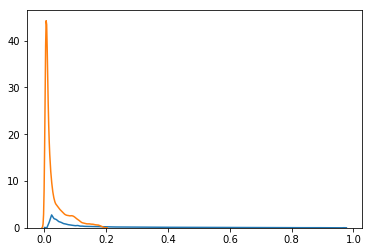

In [24]:
sns.distplot(oof_preds,hist=False,norm_hist=True)
sns.distplot(test_preds,hist=False,norm_hist=True)
plt.show()

## WRITING THE SUBMISSION FILE

In [25]:
oof=pd.DataFrame()
oof['id']=train['id']
oof['prediction']=oof_preds
oof.to_csv("oof.csv",index=False)
print(oof.shape)
oof.head()

(1804874, 2)


,id,prediction
0,59848,0.000000
1,59849,0.000000
2,59852,0.024195
3,59855,0.000000
4,59856,0.839716


In [26]:
sample['prediction']=test_preds
sample.to_csv("submission.csv",index=False)
print(sample.shape)
sample.head()

(97320, 2)


,id,prediction
0,7000000,0.010284
1,7000001,0.004150
2,7000002,0.027340
3,7000003,0.012665
4,7000004,0.165652


In [27]:
t2=datetime.datetime.now()
print("The total runtime of the kernel is",round((t2-t1).total_seconds()),"seconds")

The total runtime of the kernel is 2804 seconds
